# Initial particle density sampling
First we setup the initial distribution of the particles. This is done by defining a PDF (probability density function) which is later used to sample particles such that the resulting density field is equal to the PDF.

Note that to be useful the pdf should always be greater than 0, e.g., it may b useful to shift a pdf you want to sample by a constant factor.

Different PDFs are included here and you should paste the one you want into the field below to use it:

### Sinusoidal Sampling
This is a simple sampling with 4 peaks in the $[-1,1]$ domain. This pdf is shifted by 2 with an intensity of 1 on the sinusoidal wave, i.e., the minimum density is 1 and the maximum density is 3.
```python
pdf = lambda x: np.sin(x * np.pi * 4) + 2
```
### Low Frequency Sinusoidal Sampling
This sinusoidal sampling is of a lower frequency, i.e. there is only a single peak in the domain $[-1,1]$ but this is mostly to show an alternative way to define a pdf by using linear interpolation of an arbitrary set of datapoints.
```python
noise = 2 + np.sin(np.linspace(-np.pi, np.pi, numParticles))
pdf = lambda x : np.interp(x, np.linspace(-1,1,numParticles), noise)
```
### Square profile
This profile has a peak over $[-\frac{1}{3},\frac{1}{3}]$ where the density is at 2 and 1 everywhere else. This is useful to create a single well defined wave.
```python
def pdf(x):
    out = np.array(np.ones_like(x) * 2)
    out[np.abs(x) > 1/3] = 1
    return out
```
### Sawtooth profile
This profile creates a discontinuous profile where the sampled density changes from $2$ to $1$ at $x=0$ instantly and linearly ramps between these valus, creating a sawtooth profile.
```python
def pdf(x):
    x = np.array(x)
    out = np.array(np.ones_like(x))
    out[x > 0] = x[x>0] + 0
    out[x < 0] = x[x<0] + 2
    return out + 1
```
### Sharp Sawtooth profile
This profile has a discontinuity at $x=-1$ where the sampled density changes from $2$ to $0$. This 0 density is interesting but should be avoided due to the sampling we use.
```python
pdf = lambda x: 1 + x
```
### Triangular profile
This profile has a peak at $x=0$ with a density of $2$ and linarly ramps to $1$ at the edges of the domain
```python
pdf = lambda x: np.abs(x) + 1
```
### Gaussian profile
This profile is a smoothed variant of th above, change the standard deviation (the $8$) to change how broad the profile is.
```python
pdf = lambda x: 1 + np.exp(-(x * 8)**2) * 2
```
### Uniform profile
This profile is mostly useful for debugging as nothing should happen in this case.
```python
pdf = lambda x: np.ones_like(np.array(x))
```
### Random profile
This profile uses a periodic noise generation, using Perlin noise, to create an octav noise that can be used to generate a lot of different samplings with high frequency components that are still somewhat _smooth_
```python
noise  = 2 + generate1DPeriodicNoise(numSamples = numParticles, r = 0.75, freq = 1, octaves = 4, plot = False, seed = 1234) * 0.25
pdf = lambda x : np.interp(x, np.linspace(-1,1,numParticles), noise)
```

In [1]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, printDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleRegular, emitParticlesRegular, emitParticlesSDF
from diffSPH.v2.math import volumeToSupport
from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.sphOps import sphOperationFluidState
from torchCompactRadius.util import countUniqueEntries
from diffSPH.v2.plotting import scatterPlotFluid, scatterPlotFluidSymmetric, plotImplicitSDF
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne
from diffSPH.v2.modules.surfaceDetection import computeColorField, computeColorFieldGradient
from diffSPH.v2.modules.surfaceDetection import detectFreeSurfaceColorField, detectFreeSurfaceColorFieldGradient
from diffSPH.v2.modules.surfaceDetection import detectFreeSurfaceBarecasco
from diffSPH.v2.modules.surfaceDetection import computeSurfaceDistance, getStableSurfaceNormal
import matplotlib.pyplot as plt
import torch
import numpy as np
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict

In [14]:
config = {
    'domain': {
        'minExtent': -1,
        'maxExtent': 1,
        'dim': 1,
        'periodic': True
    },
    'particle': {
        'nx': 4096
    },
    'kernel':{
        'name': 'Wendland2'
    },
    'EOS':{
        'type': 'Tait',
        'kappa': 1.5
    }
}

config = parseDefaultParameters(config)
config = parseModuleParameters(config)

display(config)

{'domain': {'minExtent': tensor([-1.]),
  'maxExtent': tensor([1.]),
  'dim': 1,
  'periodic': True,
  'periodicity': tensor([True])},
 'particle': {'nx': 4096,
  'dx': tensor(0.0005),
  'defaultVolume': tensor(0.0005),
  'defaultSupport': 0.01220703125,
  'volume': tensor(0.0005),
  'support': 0.01220703125},
 'kernel': {'name': 'Wendland2',
  'targetNeighbors': 50,
  'function': <diffSPH.kernels.KernelWrapper at 0x7ff0f0746d10>},
 'EOS': {'type': 'Tait',
  'kappa': 1.5,
  'gasConstant': 8.14,
  'molarMass': 0.02897,
  'polytropicExponent': 7},
 'compute': {'device': 'cpu', 'precision': 'float32', 'dtype': torch.float32},
 'simulation': {'correctArea': False, 'supportScheme': 'symmetric'},
 'fluid': {'rho0': 2000, 'mu': 0.1, 'cs': 10},
 'integration': {'dt': 0.01,
  'adaptiveTimestep': False,
  'CFL': 0.25,
  'maxDt': 0.1,
  'minDt': 0.001,
  'scheme': 'semiImplicitEuler'},
 'neighborhood': {'scheme': 'compact'},
 'surfaceDetection': {'colorFieldGradientThreshold': 10.0,
  'colorField

In [15]:
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.sphOps import sphOperation
def resampleToGrid1D(simulationState, inQuantity, config, nGrid = 127):
    dx = (config['domain']['maxExtent'][0] - config['domain']['minExtent'][0]) / nGrid    
    x = torch.linspace(config['domain']['minExtent'][0] + dx/2, config['domain']['maxExtent'][0] - dx/2, nGrid).view(-1,1)
    dim = x.shape[1]
    vol = dx ** dim

    targetNeighbors = config['kernel']['targetNeighbors']
    support = volumeToSupport(vol, targetNeighbors, dim)
    xarea = torch.ones(x.shape[0]) * vol
    hx = torch.ones(x.shape[0]) * support

    i, j, rij, xij, hij, kernel, gradKernel = neighborSearch(
        x, simulationState['fluidPositions'], hx, simulationState['fluidSupports'], 
        config['kernel']['function'], config['domain']['dim'],
        config['domain']['periodicity'].detach().cpu().numpy().tolist() , config['domain']['minExtent'], config['domain']['maxExtent'], mode = 'symmetric')
    # kernel = config['kernel']['function'].kernel(rij, hij, dim)
    # gradKernel = config['kernel']['function'].kernelGradient(rij, xij, hij, dim)

    rho = sphOperation((None, simulationState['fluidMasses']), (None, simulationState['fluidDensities']), (None, inQuantity), (i, j), kernel, gradKernel, 
                    rij, xij, hij, x.shape[0],operation = 'interpolate', gradientMode = 'difference')
    
    return x, rho

def scatterPlot(fig, axis, simulationState, c, label = None, cmap = 'viridis'):
    sc = axis.plot(simulationState['fluidPositions'][:,0], c)#, lw = 2, marker = 'x', markersize = 2, linestyle = '-')
    ax1_divider = make_axes_locatable(axis)
    # cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    # cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
    if label is not None:
        axis.set_title(label)
    # if p.shape[1] > 1:
        # square = patches.Rectangle((domainMin[0], domainMin[1]), domainMax[0] - domainMin[0], domainMax[1] - domainMin[1], linewidth=1, edgecolor='b', facecolor='none',ls='--')
        # axis.add_patch(square)
    # axis.set_aspect('equal')
    # axis.set_xlim(-1.05,1.05)
    # axis.set_ylim(-1.05,1.05)

In [16]:
import copy
from diffSPH.v2.sampling import samplePDF

def pdf(x):
    x = np.array(x)
    out = np.array(np.ones_like(x))
    out[x > 0] = x[x>0] + 0
    out[x < 0] = x[x<0] + 2
    return out + 1

def pdf(x):
    out = np.array(np.ones_like(x) * 6)
    out[np.abs(x) > 1/3] = 4
    return out

# def pdf(x):
    # return np.ones_like(x)

particles = samplePDF(pdf, n = config['particle']['nx'] * 2, numParticles = config['particle']['nx'], plot = False, randomSampling = False)

In [17]:
# def generateInitialConditions(dim, nx):
#     minDomain = [-1.] * dim
#     maxDomain = [ 1.] * dim
#     # Kernel = getKernel('Wendland2')
#     # nx = 256
#     targetNeighbors = 50
#     dx = (maxDomain [0] - minDomain[0]) / nx
#     vol = dx ** dim
#     h = volumeToSupport(vol, targetNeighbors, dim)

#     print(minDomain, maxDomain)
#     x, _ = sampleRegular(dx, 1, minDomain, maxDomain, targetNeighbors, False, config['kernel']['function'])
#     hx = torch.ones(x.shape[0]) * h
#     areas = torch.ones(x.shape[0]) * vol * 2
#     print(x)
#     mask = ~((x[:,0] >= -0.25) & (x[:,0] <= 0.25)) 
    
#     x = x[mask]
#     hx = hx[mask]
#     areas = areas[mask]

#     x2, _ = sampleRegular(dx / 2, 1, minDomain, maxDomain, targetNeighbors, False, config['kernel']['function'])
#     hx2 = torch.ones(x2.shape[0]) * h
#     areas2 = torch.ones(x2.shape[0]) * vol * 2
#     mask2 = ((x2[:,0] >= -0.25) & (x2[:,0] <= 0.25)) 

#     x = torch.cat((x, x2[mask2]), 0)
#     hx = torch.cat((hx, hx2[mask2]), 0)
#     areas = torch.cat((areas, areas2[mask2]), 0)


#     # areas = areas * (4 + 3 * torch.sin(4 * x[:,0] * np.pi))
#     areas = areas
#     u = torch.zeros_like(x)

#     return x, u, hx, areas, None, minDomain, maxDomain, targetNeighbors, dx
# particles, *_ = generateInitialConditions(1, config['particle']['nx'])
# particles = torch.sort(particles, dim = 0)[0]

In [18]:
perennialState = {}

area = 2 / config['particle']['nx']
perennialState['fluidPositions'] = particles
perennialState['fluidAreas'] = particles.new_ones(particles.shape[0]) * 2 * area
perennialState['fluidMasses'] = perennialState['fluidAreas'] * config['fluid']['rho0']
perennialState['fluidSupports'] = volumeToSupport(area, config['kernel']['targetNeighbors'], config['domain']['dim'])
perennialState['fluidVelocities'] = torch.zeros_like(particles)

perennialState['numParticles'] = particles.shape[0]

perennialState['fluidNeighborhood'] = fluidNeighborSearch(perennialState, config)
perennialState['fluidDensities'] = sphOperationFluidState(perennialState, None, 'density')
_, perennialState['fluidNumNeighbors'] = countUniqueEntries(perennialState['fluidNeighborhood']['indices'][0], perennialState['fluidPositions'])

initialState = copy.deepcopy(perennialState)

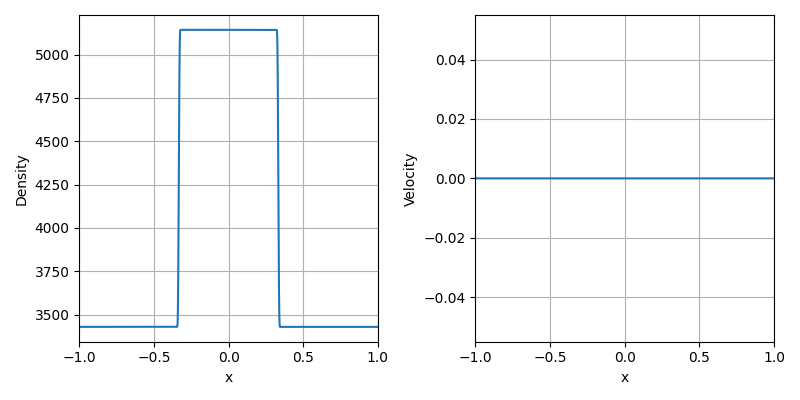

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

perennialState = copy.deepcopy(initialState)
        
fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)


xx, rhox = resampleToGrid1D(perennialState, perennialState['fluidDensities'], config, config['particle']['nx'])
xx, ux   = resampleToGrid1D(perennialState, perennialState['fluidVelocities'], config, config['particle']['nx'])

axis[0,0].plot(xx, rhox)
axis[0,1].plot(xx, ux)
for xax in axis:
    for ax in xax:
        # ax.set_title('Density')
        ax.set_xlabel('x')
        # ax.set_ylabel('Density')
        ax.set_xlim(-1, 1)
        ax.grid(True)
        # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)

axis[0,0].set_ylabel('Density')
axis[0,1].set_ylabel('Velocity')
# scatterPlot(fig, axis[0,0], simulationState, simulationState['fluidNumNeighbors'], 'Number of Neighbors[ni]')

# rho = sphOperation((areas, areas), (ones, ones), (ones, ones), (i, j), Wij, gradWij, xij, rij, hij, particles.shape[0], operation = 'interpolate')
# # print(rho)

# scatterPlot(fig, axis[0,1], simulationState, simulationState['fluidDensities'], '$\\rho$')

fig.tight_layout()

In [20]:
from diffSPH.v2.modules.pressureEOS import computeEOS
from diffSPH.v2.modules.pressureForce import computePressureAccel
from diffSPH.v2.modules.viscosity import computeViscosityMonaghan


# def fluidNeighborSearch(simulationState: dict, config: dict):
#     i, j, rij, xij, hij, Wij, gradWij = neighborSearch(simulationState['fluidPositions'], simulationState['fluidPositions'], simulationState['fluidSupports'], simulationState['fluidSupports'], kernel = config['kernel']['function'], dim = config['domain']['dim'], periodic = config['domain']['periodicity'], minDomain = config['domain']['minExtent'], maxDomain = config['domain']['maxExtent'], algorithm = 'small')
#     neighborDict = {
#         'indices': (i, j),
#         'distances': rij,
#         'vectors': xij,
#         'supports': hij,
#         'kernels': Wij,
#         'gradients': gradWij,
#     }
#     return neighborDict


def simulationStep(simulationState, config):
    simulationState['fluidNeighborhood'] = fluidNeighborSearch(simulationState, config)
    simulationState['fluidDensities'] = sphOperationFluidState(simulationState, None, 'density')

    simulationState['fluidPressures'] = computeEOS(simulationState, config)
    # simulationState['fluidPressures'] = 1.5 * (simulationState['fluidDensities'] - config['fluid']['rho0'])
    simulationState['fluidPressureAccel'] = computePressureAccel(simulationState, config) #sphOperationFluidState(simulationState, (simulationState['fluidPressures'], simulationState['fluidPressures']), operation = 'gradient', gradientMode='symmetric') / simulationState['fluidDensities'].view(-1,1) #computePressureForce(simulationState, config)
    simulationState['fluidViscosityAccel'] = computeViscosityMonaghan(simulationState, config)

    dudt = simulationState['fluidPressureAccel'] + simulationState['fluidViscosityAccel']# * simulationState['fluidDensities'].view(-1,1)

    
    # for j in range(16):
        # print(f'[{j}] {simulationState["fluidVelocities"][j]} {simulationState["fluidPositions"][j]} {simulationState["fluidPressureForces"][j]} {simulationState["fluidViscosityForces"][j]} {dudt[j]}')


    return dudt

In [21]:
# def integrate(perennialState, config, previousStep, simulationStep, scheme = 'semiImplicitEuler'):
#     dt = config['integration']['dt']

#     if scheme == 'semiImplicitEuler':
#         dudt = simulationStep(perennialState, config)
#         perennialState['fluidVelocities'] += dudt * dt
#         perennialState['fluidPositions'] += perennialState['fluidVelocities'] * dt
#     elif scheme == 'explicitEuler':
#         dudt = simulationStep(perennialState, config)
#         perennialState['fluidPositions'] += perennialState['fluidVelocities'] * dt
#         perennialState['fluidVelocities'] += dudt * dt
#     elif scheme == 'verlet':
#         if previousStep is None:
#             previousStep = simulationStep(perennialState, config)
        
#         perennialState['fluidPositions'] += perennialState['fluidVelocities'] * dt + 0.5 * previousStep * dt ** 2
#         dudt = simulationStep(perennialState, config)
#         perennialState['fluidVelocities'] += 0.5 * (dudt + previousStep) * dt
#     elif scheme == 'leapfrog':
#         if previousStep is None:
#             previousStep = simulationStep(perennialState, config)

#         # Compute the new velocity at t + dt/2
#         perennialState['fluidVelocities'] += 0.5 * previousStep * dt

#         # Compute the new position at t + dt
#         perennialState['fluidPositions'] += perennialState['fluidVelocities'] * dt

#         # Compute the new acceleration at t + dt
#         dudt = simulationStep(perennialState, config)

#         # Compute the new velocity at t + dt
#         perennialState['fluidVelocities'] += 0.5 * dudt * dt
#     elif scheme == 'RK4':
#         # Compute k1
#         k1 = simulationStep(perennialState, config)
#         tempState = copy.deepcopy(perennialState)
#         tempState['fluidVelocities'] += k1 * dt / 2
#         tempState['fluidPositions'] += perennialState['fluidVelocities'] * dt / 2

#         # Compute k2
#         k2 = simulationStep(tempState, config)
#         tempState = copy.deepcopy(perennialState)
#         tempState['fluidVelocities'] += k2 * dt / 2
#         tempState['fluidPositions'] += (perennialState['fluidVelocities'] + k1 * dt / 2) * dt / 2

#         # Compute k3
#         k3 = simulationStep(tempState, config)
#         tempState = copy.deepcopy(perennialState)
#         tempState['fluidVelocities'] += k3 * dt
#         tempState['fluidPositions'] += (perennialState['fluidVelocities'] + k2 * dt / 2) * dt

#         # Compute k4
#         k4 = simulationStep(tempState, config)

#         # Update the position and velocity
#         perennialState['fluidPositions'] += dt * (perennialState['fluidVelocities'] + (k1 + 2*k2 + 2*k3 + k4) * dt / 6)
#         perennialState['fluidVelocities'] += (k1 + 2*k2 + 2*k3 + k4) * dt / 6
#         dudt = (k1 + 2*k2 + 2*k3 + k4) * dt / 6
#     return perennialState, dudt

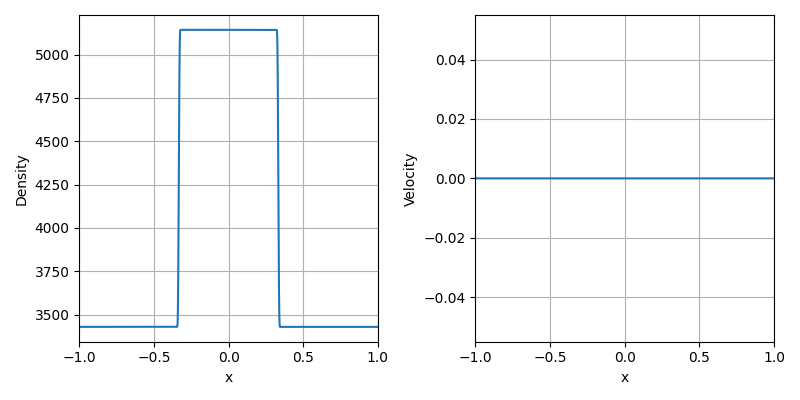

In [29]:
simulationState = {}

config['integration']['dt'] = 0.001
config['fluid']['mu'] = 0.001

perennialState = copy.deepcopy(initialState)

perennialState['numParticles'] = perennialState['fluidPositions'].shape[0]

perennialState['fluidNeighborhood'] = fluidNeighborSearch(perennialState, config)
perennialState['fluidDensities'] = sphOperationFluidState(perennialState, None, 'density')
_, perennialState['fluidNumNeighbors'] = countUniqueEntries(perennialState['fluidNeighborhood']['indices'][0], perennialState['fluidPositions'])



xx, rhox = resampleToGrid1D(perennialState, perennialState['fluidDensities'], config, config['particle']['nx'])
xx, ux   = resampleToGrid1D(perennialState, perennialState['fluidVelocities'], config, config['particle']['nx'])


fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)

axis[0,0].plot(xx, rhox)
axis[0,1].plot(xx, ux)
for xax in axis:
    for ax in xax:
        # ax.set_title('Density')
        ax.set_xlabel('x')
        # ax.set_ylabel('Density')
        ax.set_xlim(-1, 1)
        ax.grid(True)
        # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)

axis[0,0].set_ylabel('Density')
axis[0,1].set_ylabel('Velocity')

fig.tight_layout()
fig.canvas.draw()
fig.canvas.flush_events()

simulationStates = []

In [28]:
from tqdm.autonotebook import tqdm
import copy

dudt = None

import matplotlib.pyplot as plt
import matplotlib.colors as colors

norm = colors.Normalize(vmin=0, vmax=2048)
cmap = plt.cm.get_cmap('viridis')

# Use the colormap to get colors based on the norm
# color = cmap(norm)

for i in tqdm(range(2048)):
    perennialState, dudt = integrate(simulationStep, perennialState, config, previousStep= dudt)

    # dudt = simulationStep(simulationState, config)
    simulationStates.append(copy.deepcopy(perennialState))
    # simulationState['fluidVelocities'] += dudt * config['integration']['dt']
    # simulationState['fluidPositions'] += simulationState['fluidVelocities'] * config['integration']['dt']

    if i % 16 == 0:
        xx, rhox = resampleToGrid1D(perennialState, perennialState['fluidDensities'], config, config['particle']['nx'])
        xx, ux   = resampleToGrid1D(perennialState, perennialState['fluidVelocities'], config, config['particle']['nx'])

        axis[0,0].lines[0].remove()
        axis[0,1].lines[0].remove()

        axis[0,0].plot(xx, rhox, c = cmap(norm(i)))
        axis[0,1].plot(xx, ux, c = cmap(norm(i)))
        
        fig.canvas.draw()
        fig.canvas.flush_events()
    # break

  0%|          | 0/2048 [00:00<?, ?it/s]

In [40]:
len(simulationStates)

1025

In [21]:
# from torch.profiler import profile, record_function, ProfilerActivity

# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=False, profile_memory=True) as prof:    
#     for i in range(32):
#         with record_function("numpy"): 
#            simulationStep(simulationState, config)
        
# # print(prof.key_averages().table(sort_by='self_cpu_time_total'))
# print(prof.key_averages().table(sort_by='cpu_time_total'))

# prof.export_chrome_trace("traceGPU.json")

STAGE:2024-02-20 11:08:19 1125034:1125034 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-02-20 11:08:19 1125034:1125034 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-02-20 11:08:19 1125034:1125034 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


-----------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                     Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-----------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                    numpy         1.81%       4.506ms        99.99%     248.535ms       7.767ms       2.81 Mb     -87.57 Mb            32  
                           NeighborSearch         1.05%       2.614ms        65.89%     163.764ms       5.118ms      89.60 Mb           0 b            32  
            NeighborSearch [radiusSearch]        41.70%     103.655ms        43.54%     108.229ms       3.382ms      39.68 Mb      -1.52 Mb            32  
                             sphOperation         1.53%       3.

In [16]:
# %timeit torch.linalg.norm(v, dim = -1, ord = 2)
# %timeit np.linalg.norm(v.numpy(), axis = -1)
# %timeit (v[:,0] ** 2) ** 0.5

9.31 ms ± 6.34 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
69.6 µs ± 132 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
32.2 µs ± 189 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [45]:
# torch.norm(v, dim = -1, p = 2)
# (v[:,0] ** 2) ** 0.5
# v.shape

torch.Size([81274, 1])

In [47]:
# x = torch.randn(81274, 1)
# y = torch.randn(81274, 1)
# %timeit torch.sqrt((x - y).pow(2).sum(1))
# %timeit torch.norm(x - y, 2, 1)
# x = x.cuda()
# y = y.cuda()
# %timeit torch.sqrt((x - y).pow(2).sum(1))
# %timeit torch.norm(x - y, 2, 1)

90 µs ± 5.66 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
5.58 ms ± 196 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


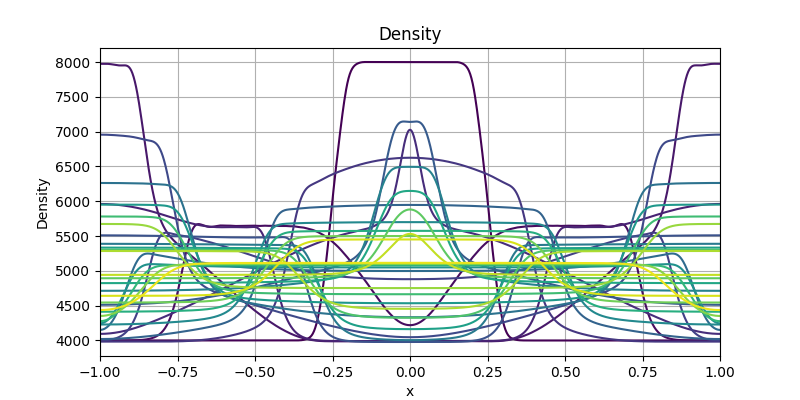

In [41]:
xx, rhox = resampleToGrid1D(perennialState, simulationStates[i]['fluidDensities'], config, config['particle']['nx'])
fig, axis = plt.subplots(1, 1, figsize=(8,4), sharex = True, sharey = True, squeeze = False)

import matplotlib.cm as cm
import matplotlib.colors as colors

cmap = cm.get_cmap('viridis')
norm = colors.Normalize(vmin=0, vmax=len(simulationStates) * config['integration']['dt'])


for i in range(1, len(simulationStates), 32):
    xx, rhox = resampleToGrid1D(simulationStates[i], simulationStates[i]['fluidDensities'], config, config['particle']['nx'])
    axis[0,0].plot(xx, rhox, label = 't = {}'.format(i * config['integration']['dt']), c = cmap(norm(i * config['integration']['dt'])))

# axis[0,0].plot(xx, rhox)
axis[0,0].set_title('Density')
axis[0,0].set_xlabel('x')
axis[0,0].set_ylabel('Density')
axis[0,0].set_xlim(-1, 1)
axis[0,0].grid(True)
axis[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
axis[0,0].set_title('Density')
axis[0,0].set_xlabel('x')
axis[0,0].set_ylabel('Density')
axis[0,0].set_xlim(-1, 1)
axis[0,0].grid(True)

fig.tight_layout()

torch.Size([1024, 1]) torch.Size([1024])
torch.Size([1024, 1025]) torch.Size([1024, 1025]) torch.Size([1024, 1025])


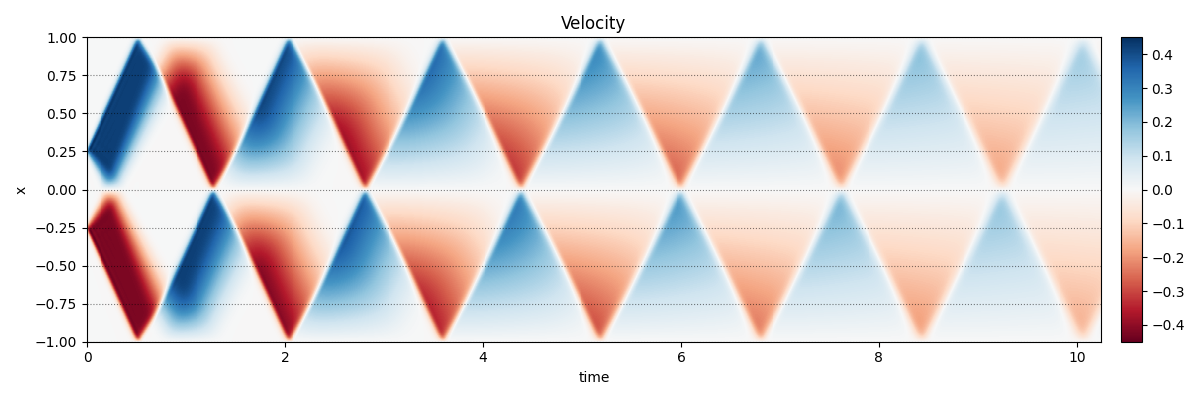

In [42]:
gridData = [
    resampleToGrid1D(simulationStates[i], simulationStates[i]['fluidVelocities'][:,0], config, config['particle']['nx']) for i in range(len(simulationStates))]
print(gridData[0][0].shape, gridData[0][1].shape)

xxs = torch.stack([x[:,0] for x, rho in gridData], dim=1)
rhos = torch.stack([rho for x, rho in gridData], dim=1)
ts = torch.stack([torch.ones(xxs.shape[0])* i * config['integration']['dt'] for i in range(len(simulationStates))], dim=1)
print(xxs.shape, rhos.shape, ts.shape)


fig, axis = plt.subplots(1, 1, figsize=(12,4), sharex = True, sharey = True, squeeze = False)
# im = axis[0,0].scatter(xxs, ts, c = rhos, s = 1)

im = axis[0,0].pcolormesh(ts.mT.numpy(), xxs.mT.numpy(), rhos.mT.numpy(), cmap = 'RdBu')
axis[0,0].set_title('Velocity')
axis[0,0].set_ylabel('x')
axis[0,0].set_xlabel('time')
axis[0,0].set_ylim(-1, 1)
axis[0,0].grid(axis = 'y', ls = ':', alpha = 0.5, c = 'black')
# axis[0,0].set_xscale('log')

divider = make_axes_locatable(axis[0,0])
cax = divider.append_axes("right", size="2%", pad='2%')
fig.colorbar(im, cax=cax, orientation='vertical')
fig.tight_layout()


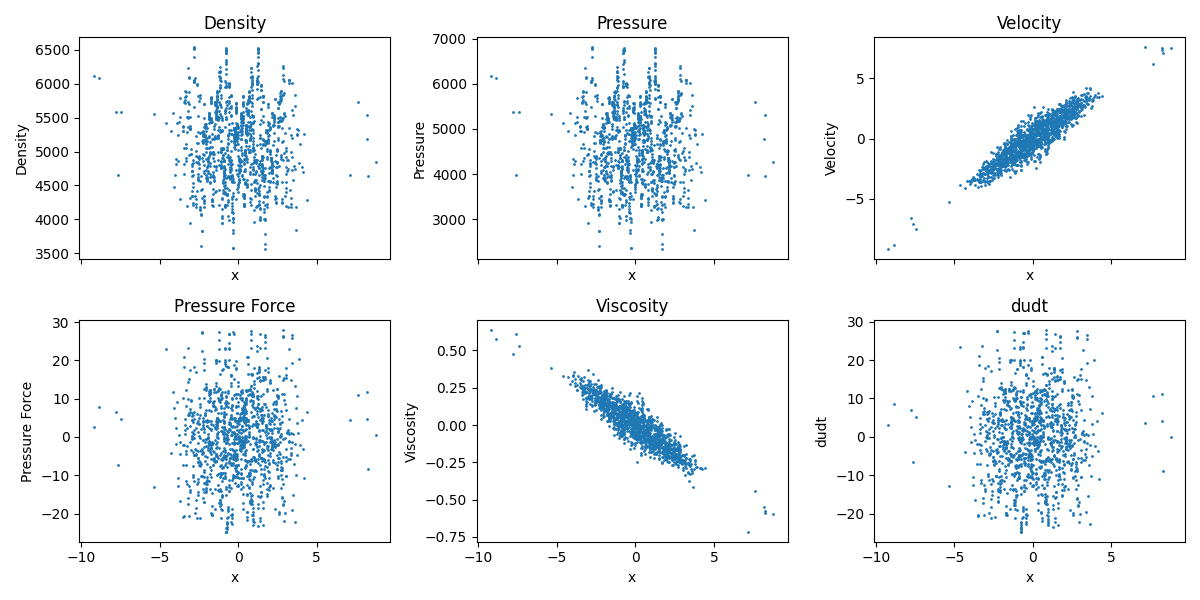

In [23]:

fig, axis = plt.subplots(2, 3, figsize=(12,6), sharex = True, sharey = False, squeeze = False)

axis[0,0].scatter(particles[:,0], simulationState['fluidDensities'], s = 1)
axis[0,0].set_title('Density')  
axis[0,0].set_xlabel('x')
axis[0,0].set_ylabel('Density')

axis[0,1].scatter(particles[:,0], simulationState['fluidPressures'], s = 1)
axis[0,1].set_title('Pressure')
axis[0,1].set_xlabel('x')
axis[0,1].set_ylabel('Pressure')

axis[0,2].scatter(particles[:,0], simulationState['fluidVelocities'][:,0], s = 1)
axis[0,2].set_title('Velocity')
axis[0,2].set_xlabel('x')
axis[0,2].set_ylabel('Velocity')

axis[1,0].scatter(particles[:,0], simulationState['fluidPressureForces'], s = 1)
axis[1,0].set_title('Pressure Force')
axis[1,0].set_xlabel('x')
axis[1,0].set_ylabel('Pressure Force')

axis[1,1].scatter(particles[:,0], simulationState['fluidViscosityForces'], s = 1)
axis[1,1].set_title('Viscosity')
axis[1,1].set_xlabel('x')
axis[1,1].set_ylabel('Viscosity')

axis[1,2].scatter(particles[:,0], dudt, s = 1)
axis[1,2].set_title('dudt')
axis[1,2].set_xlabel('x')
axis[1,2].set_ylabel('dudt')

# simulationState['rho']
fig.tight_layout()

In [17]:
particles.shape

torch.Size([1280, 1])

In [40]:
simulationState['fluidMasses'][0].item() / 2000
torch.float32

torch.float32

In [41]:

simulationState['fluidNeighborhood'] = fluidNeighborSearch(simulationState, config)
simulationState['fluidDensities'] = sphOperationFluidState(simulationState, None, 'density')
_, simulationState['fluidNumNeighbors'] = countUniqueEntries(simulationState['fluidNeighborhood']['indices'][0], simulationState['fluidPositions'])


In [42]:
simulationState['fluidNumNeighbors']

tensor([49, 49, 49,  ..., 49, 49, 49])

In [43]:
simulationState['fluidNeighborhood']

{'indices': (tensor([   0,    0,    0,  ..., 1023, 1023, 1023]),
  tensor([1012, 1013, 1014,  ...,    9,   10,   11])),
 'distances': tensor([0.4800, 0.4400, 0.4000,  ..., 0.4000, 0.4400, 0.4800]),
 'vectors': tensor([[-1.],
         [-1.],
         [-1.],
         ...,
         [ 1.],
         [ 1.],
         [ 1.]]),
 'supports': tensor([0.0488, 0.0488, 0.0488,  ..., 0.0488, 0.0488, 0.0488]),
 'kernels': tensor([ 8.7829, 10.4302, 12.1651,  ..., 12.1651, 10.4302,  8.7829]),
 'gradients': tensor([[ 816.5806],
         [ 868.1202],
         [ 905.9698],
         ...,
         [-905.9698],
         [-868.1202],
         [-816.5806]])}

Text(0.5, 1.0, 'Kernels')

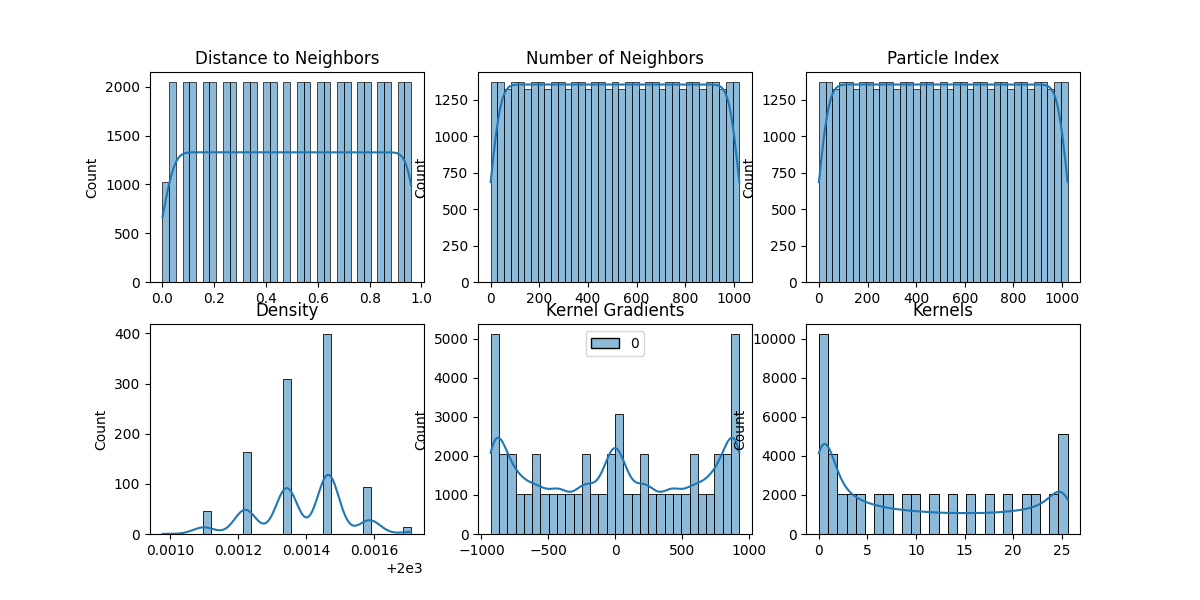

In [44]:
import seaborn as sns



fig, axis = plt.subplots(2, 3, figsize=(12,6), sharex = False, sharey = False, squeeze = False)
sns.histplot(simulationState['fluidNeighborhood']['distances'], kde=True, ax = axis[0,0])
axis[0,0].set_title('Distance to Neighbors')
sns.histplot(simulationState['fluidNeighborhood']['indices'][1], kde=True, ax = axis[0,1])
axis[0,1].set_title('Number of Neighbors')
sns.histplot(simulationState['fluidNeighborhood']['indices'][0], kde=True, ax = axis[0,2])
axis[0,2].set_title('Particle Index')

sns.histplot(simulationState['fluidDensities'], kde=True, ax = axis[1,0])
axis[1,0].set_title('Density')


sns.histplot(simulationState['fluidNeighborhood']['gradients'], kde=True, ax = axis[1,1])
axis[1,1].set_title('Kernel Gradients')

sns.histplot(simulationState['fluidNeighborhood']['kernels'], kde=True, ax = axis[1,2])
axis[1,2].set_title('Kernels')
